#  Прогнозирование заказов такси

Сервис такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке.

**Содержание:**

    1  Подготовка
    2  Анализ
    3  Обучение
        3.1  Создание признаков
        3.2  Разделение на выборки
        3.3  Обучение моделей
        3.4  Проверка модели на адекватность
    4  Тестирование

In [1]:
import pandas as pd # импорт библиотеки pandas
import numpy as np # импорт библиотеки numpy
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import seaborn as sns # импорт библиотеки seaborn
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV # импорт из библиотеки sklearn алгоритма TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer # импорт из библиотеки sklearn алгоритма make_scorer, mean_absolute_error
from sklearn.linear_model import LinearRegression # импорт из библиотеки sklearn алгоритма линейной регрессии
from sklearn.dummy import DummyRegressor # импорт из библиотеки sklearn алгоритма DummyRegressor
from lightgbm import LGBMRegressor # импорт алгоритма LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose # импорт из библиотеки statsmodels.tsa.seasonal алгоритма seasonal_decompose

## 1 Подготовка

In [2]:
# знакомство с данными
df = pd.read_csv('***.csv', index_col=[0], parse_dates=[0])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
df.sort_index(inplace=True) # отсортируем по индексу
df = df.resample('1H').sum() # ресамплируем по 1 часу

Пропусков нет. Других проблем в данных нет.

## 2 Анализ

Посморим на тренд и сезонность

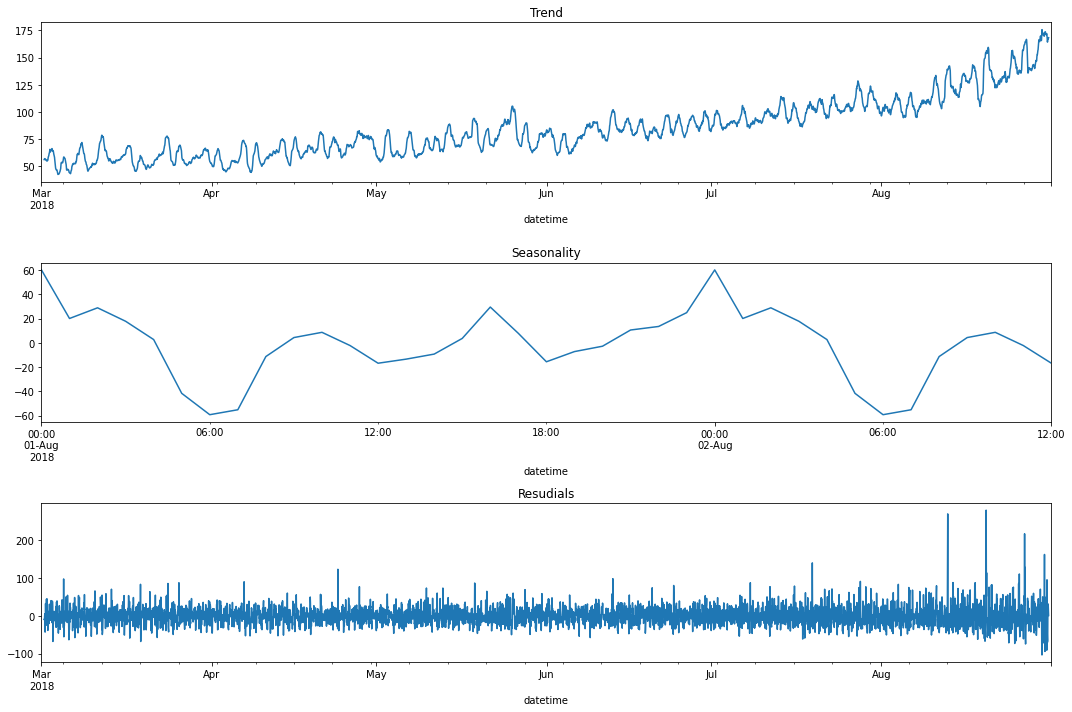

In [5]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca()) # тренд
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-02 12:00:00'].plot(ax=plt.gca()) # сезонность
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # остаток декомпозиции
plt.title('Resudials')
plt.tight_layout()

Мы наблюдаем:
- Плавное увелечние заказов с мая. Март и Апрель примерно равны.
- Стремительное увеличение заказов с середины августа. Это связано скорей всего с началом учебного года.
- Пики заказов приходятся на начало и конец рабочего дня, а так же к 12 часам ночи.

## 3 Обучение

### 3.1 Создание признаков

In [6]:
# функция создания признаков: месяц, день месяца, день недели, час, столбцы с отставанием, скользящее среднее
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [7]:
make_features(df, 7, 12)
df.head()

,num_orders,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN


### 3.2 Разделение на выборки

In [8]:
df = df.dropna() # удаление пустых значений
features = df.drop('num_orders', axis=1).values # признаки
target = df['num_orders'].values # целевой признак

Используем кросс валидацию для временных рядов:

Нам нужно использовать тестовую выборку 10% от исходных данных. В процентном соотношении TimeSeriesSplit() не принимает размер выборки, поэтому будем использовать следующую формулу (по умолчанию n_splits=5): test_size=int((len(features)/5)*0.5)

In [9]:
tscv = TimeSeriesSplit(test_size=int((len(features)/5)*0.5))
for train_index, test_index in tscv.split(features):
    features_train, features_test = features[train_index], features[test_index]
    target_train, target_test = target[train_index], target[test_index]

Проверка разделения выборок:

In [10]:
print('Обучающая выборка:',round(features_train.shape[0]/df.shape[0]*100,1),'%')
print('Тестовая выборка:',round(features_test.shape[0]/df.shape[0]*100,1),'%')

Обучающая выборка: 90.0 %
Тестовая выборка: 10.0 %


### 3.3 Обучение моделей

Возьмем для сравнения 2 модели: Линейную регрессию и модель градиентного бустинга LGBMRegressor. У нас не стоит задачи сравнивать много моделей. Эти 2 модели быстро обучаются, что сэкономит нам время. Плюс LightGBM дает хороший результат предсказаний.

In [11]:
mse = make_scorer(mean_squared_error, greater_is_better=False) # метрику среднекврадратичной ошибки 

In [12]:
model_lr = LinearRegression() # линейная регрессия
model_lgbm = LGBMRegressor() # LightGBM

In [13]:
# подбор гиперпараметров для моделей (оставлены лучшие параметры)
grid_lr = {}
grid_lgbm = {'max_depth':[10],
             'num_leaves':[20],
             'random_state':[42]}

In [14]:
# кросс-валидация и поиск лучших параметров для моделей
lr = GridSearchCV(model_lr, param_grid=grid_lr, cv = tscv, scoring = mse)
lgbm = GridSearchCV(model_lgbm, param_grid=grid_lgbm, cv = tscv, scoring = mse)

In [15]:
# обучение моделей
lr.fit(features_train, target_train)
lgbm.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=440),
             estimator=LGBMRegressor(),
             param_grid={'max_depth': [10], 'num_leaves': [20],
                         'random_state': [42]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [16]:
# вывод лучших гиперпараметров модели
lgbm.best_estimator_

LGBMRegressor(max_depth=10, num_leaves=20, random_state=42)

In [17]:
print('RMSE Линейной Регрессии:', abs(lr.best_score_)**0.5)
print('RMSE LightGBM:', abs(lgbm.best_score_)**0.5)

RMSE Линейной Регрессии: 33.624415744830905
RMSE LightGBM: 25.799823686926196


Модели обучены. Метрики показывают хорошие результаты, проверим их на константной модели.

### 3.4 Проверка модели на адекватность

In [18]:
# вызов константной модели
dummy = DummyRegressor(strategy="mean")
# обучение модели
dummy.fit(features_train,target_train)
# предсказания модели
prediction_dummy = dummy.predict(features_test)
print('RMSE константной модели на тестовой выборке:', mean_squared_error(target_test, prediction_dummy)**0.5)

RMSE константной модели на тестовой выборке: 84.73546468724061


Обе модели прошли тест на адекватность.

## 4 Тестирование

In [19]:
predict_test_lr = lr.predict(features_test)
predict_test_lgbm = lgbm.predict(features_test)

print('RMSE Линейной Регрессии:', mean_squared_error(target_test, predict_test_lr)**0.5)
print('RMSE LightGBM:', mean_squared_error(target_test, predict_test_lgbm)**0.5)

RMSE Линейной Регрессии: 52.6979515205831
RMSE LightGBM: 42.69127052112793


Построим график предсказаний и целевого признака.

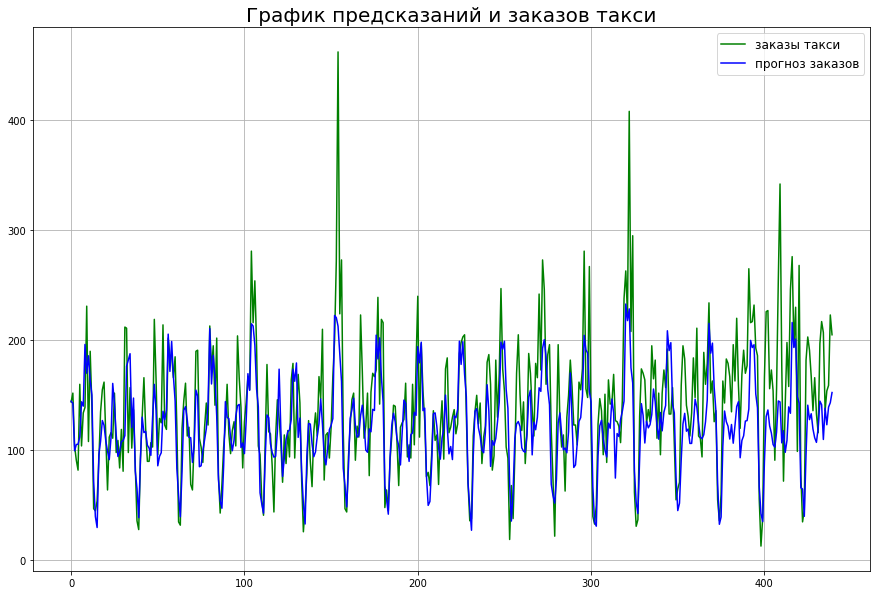

In [21]:
plt.figure(figsize=(15,10))
plt.title('График предсказаний и заказов такси', fontsize=20)
sns.lineplot(data=target_test, color='g')
sns.lineplot(data=predict_test_lgbm, color='b')
plt.legend(['заказы такси', 'прогноз заказов'], fontsize=12)
plt.grid()
plt.show()

**Вывод:**

- У LightGBM RMSE = 42.69 на тестовой выборке, что явно меньше 48 в условии задачи. Гиперпараметры подобраны хорошо, модель справилась с поставленной задачей.
- У Линейной Регрессии RMSE = 52.6 на тестовой выборке, что явно больше 48. Линейная регрессия не годится для данной задачи.
- Модели хорошо удается предсказывать сезонность, но пиковые нагрузки не удаются. Возможно это связано с праздниками, либо другими мероприятиями, не отраженными в признаках.
- Выборки были разделены с помощью TimeSeriesSplit, разработанного специально для временных рядов.
- Использована кросс-валидация для достижения лучшего результата.